# Linear Learner Demo - Multi-class Classification

This notebook demonstrates how to use AWS SageMaker's Linear Learner algorithm for **multi-class classification** - predicting one of three or more possible categories.

---

## Business Context

### What business problem does this solve?

Multi-class classification helps businesses categorize items into more than two groups. This is useful when you need finer distinctions than simple yes/no decisions.

### Real-world SMB Example: Categorizing House Price Tiers

Imagine you run a small real estate agency. Instead of just "above or below median," you want to categorize houses into price tiers:

- **Class 0 (Budget)**: Lower third of the market - starter homes, first-time buyers
- **Class 1 (Mid-Range)**: Middle third - typical family homes, most common segment
- **Class 2 (Premium)**: Upper third - luxury features, high-end buyers

This helps you:
- **Target marketing**: Different advertising strategies for each price tier
- **Match clients**: Connect buyers with appropriate properties faster
- **Staff allocation**: Assign agents based on their expertise with different market segments

In this demo, we'll predict which price tier (0, 1, or 2) a house belongs to.

---

**Prerequisites**: You must have already run the `LinearLearner_Data_Validator.ipynb` notebook, which produces a cleaned CSV file ready for SageMaker.

---
## Step 1: Setup and Configuration

First, we need to import the Python libraries (pre-written code packages) that we'll use throughout this notebook.

**What each library does:**
- `pandas` (pd): Works with data tables (like Excel spreadsheets) - a **DataFrame** is a table of data with rows and columns
- `numpy` (np): Performs mathematical calculations on numbers and arrays
- `sklearn`: Provides tools for splitting data and measuring model performance
- `boto3`: Connects Python to Amazon Web Services (AWS) - AWS is Amazon's cloud computing platform
- `sagemaker`: Amazon's machine learning service that trains and hosts models

**What to expect:** After running this cell, you'll see a confirmation that all libraries loaded successfully.

In [1]:
# ============================================================
# CONFIGURATION - THE ONLY CELL YOU NEED TO EDIT!
# ============================================================
# 
# FOR YOUR OWN PROJECT, CHANGE THESE 4 THINGS:
#   1. CLEANED_DATA_FILE - your cleaned CSV from Data Validator
#   2. PROJECT_NAME - a short name for your project  
#   3. ENDPOINT_NAME - a unique name for your model endpoint
#   4. NUM_CLASSES - how many categories you are predicting
#
# That's it! Everything else runs automatically.
# ============================================================

# 1. Your cleaned CSV file (output from Data Validator notebook)
#    For the demo, we use the pre-configured multi-class dataset
CLEANED_DATA_FILE = "AmesHousing_MULTICLASS.csv"

# 2. Project name (used for organizing files in S3 cloud storage)
#    Use only letters, numbers, and hyphens - NO SPACES
PROJECT_NAME = "multiclass-housing-demo"

# 3. Endpoint name (the "address" for your prediction service)
#    Use only letters, numbers, and hyphens - NO SPACES
ENDPOINT_NAME = "multiclass-learner-endpoint"

# 4. Number of classes (categories) to predict
#    Must match the number of unique values in your target column
#    Example: 3 for Budget/Mid-Range/Premium, 4 for A/B/C/D ratings
NUM_CLASSES = 3

# ============================================================
# DON'T CHANGE ANYTHING BELOW THIS LINE
# (unless you know what you're doing!)
# ============================================================

print("Configuration loaded!")
print(f"  Data file:     {CLEANED_DATA_FILE}")
print(f"  Project name:  {PROJECT_NAME}")
print(f"  Endpoint name: {ENDPOINT_NAME}")
print(f"  Num classes:   {NUM_CLASSES}")

Configuration loaded!
  Data file:     AmesHousing_MULTICLASS.csv
  Project name:  multiclass-housing-demo
  Endpoint name: multiclass-learner-endpoint
  Num classes:   3


In [2]:
# Import data handling libraries
import pandas as pd      # For working with data tables (DataFrames)
import numpy as np       # For numerical operations

# Import visualization library
import matplotlib.pyplot as plt  # For creating charts and graphs

# Import machine learning utilities from scikit-learn
from sklearn.model_selection import train_test_split  # Splits data into training and testing sets
from sklearn.metrics import (                         # Tools to measure how well the model performs
    accuracy_score,      # What percentage of predictions were correct?
    precision_score,     # Of all predictions for a class, how many were correct?
    recall_score,        # Of all actual instances of a class, how many did we find?
    f1_score,            # A balanced measure combining precision and recall
    confusion_matrix,    # Shows correct vs incorrect predictions in a grid
    classification_report  # Detailed performance breakdown
)

# Import AWS libraries
import boto3             # AWS SDK - lets Python talk to AWS services
import sagemaker         # Amazon's machine learning platform
from sagemaker import Session, get_execution_role  # Session management and permissions
from sagemaker.estimator import Estimator          # Used to configure and train models
from sagemaker.inputs import TrainingInput         # Tells SageMaker where training data is located
from sagemaker.serializers import CSVSerializer    # Formats data as CSV for the model
from sagemaker.deserializers import JSONDeserializer  # Reads JSON responses from the model

print("All libraries imported successfully!")
print(f"SageMaker SDK version: {sagemaker.__version__}")

Unable to load JumpStart region config.
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.12/site-packages/sagemaker/jumpstart/constants.py", line 69, in _load_region_config
    with open(filepath) as f:
         ^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/home/ec2-user/anaconda3/envs/python3/lib/python3.12/site-packages/sagemaker/jumpstart/region_config.json'


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
All libraries imported successfully!
SageMaker SDK version: 2.256.1


---
## Step 2: Load Prepared Data

We'll load the cleaned CSV file that was produced by the Data Validator notebook.

**Important**: The Data Validator already:
- Removed columns with too many missing values
- Filled in remaining missing values
- Converted text categories to numbers
- Moved the target column to the first position
- Removed headers (SageMaker Linear Learner requires no headers)

**What is a DataFrame?**
A DataFrame is like a spreadsheet or Excel table in Python. It has rows (individual records) and columns (different attributes or features).

**What to expect:** You'll see the number of rows and columns in your data, plus a breakdown of how many samples are in each class.

In [3]:
# Load the cleaned data file
# header=None tells pandas there are no column names in the file
df = pd.read_csv(CLEANED_DATA_FILE, header=None)

# The first column (index 0) is the target variable (what we want to predict)
# All other columns are features (the information we use to make predictions)
print("="*60)
print("DATA LOADED SUCCESSFULLY")
print("="*60)
print(f"Number of rows (samples): {len(df):,}")
print(f"Number of columns: {len(df.columns)} (1 target + {len(df.columns)-1} features)")
print()

# Verify the data looks correct
print("First 5 rows of the dataset:")
print("(Column 0 is the target variable, columns 1+ are features)")
print(df.head())

DATA LOADED SUCCESSFULLY
Number of rows (samples): 2,930
Number of columns: 198 (1 target + 197 features)

First 5 rows of the dataset:
(Column 0 is the target variable, columns 1+ are features)
   0     1      2        3         4    5    6       7       8         9    \
0    2  20.0  141.0  31770.0  0.151195  6.0  5.0  1960.0  1960.0  0.030034   
1    0  20.0   80.0  11622.0  0.151195  5.0  6.0  1961.0  1961.0  0.350171   
2    1  20.0   81.0  14267.0  0.151195  6.0  6.0  1958.0  1958.0  0.143345   
3    2  20.0   93.0  11160.0  0.151195  7.0  5.0  1968.0  1968.0  0.030034   
4    1  60.0   74.0  13830.0  0.056314  5.0  5.0  1997.0  1998.0  0.350171   

   ...  188  189  190  191  192  193  194  195  196  197  
0  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  
1  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  
2  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  
3  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  
4  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0

### Verify Multi-class Classification Target

The pre-configured dataset (`AmesHousing_MULTICLASS.csv`) already has the target transformed to three price tiers:
- **Class 0 (Budget)**: Houses in the lower third of prices (below $139,000)
- **Class 1 (Mid-Range)**: Houses in the middle third of prices ($139,000 - $190,000)
- **Class 2 (Premium)**: Houses in the upper third of prices (above $190,000)

**Why pre-configured data?**
Using pre-configured datasets ensures everyone in the class sees the same results during the demo. When you use the Data Validator notebook for your own project, you will need to ensure your target variable is coded as consecutive integers starting at 0 (i.e., 0, 1, 2, ...).

**Important for your own projects:** Linear Learner requires class labels to be consecutive integers starting from 0. If your categories are 1, 2, 3 you must convert them to 0, 1, 2.

**What to expect:** You will see confirmation that the target column contains the expected number of classes.

In [4]:
# ============================================================
# VERIFY MULTI-CLASS CLASSIFICATION TARGET
# ============================================================
# The pre-configured dataset should already have class labels (0, 1, 2)
# in the first column. Let's verify this matches NUM_CLASSES.
# ============================================================

# Get the target column
target_column = df.iloc[:, 0]

# Check unique values
unique_values = sorted(target_column.unique())
num_unique = len(unique_values)

# Define class names for our real estate example
class_names = {0: 'Budget', 1: 'Mid-Range', 2: 'Premium'}

print("="*60)
print("TARGET VERIFICATION")
print("="*60)
print(f"Unique values in target column: {unique_values}")
print(f"Number of classes found: {num_unique}")
print(f"NUM_CLASSES configured: {NUM_CLASSES}")
print()

# Verify the classes match expectations
expected_classes = list(range(NUM_CLASSES))
if list(map(int, unique_values)) == expected_classes:
    print("SUCCESS: Target column contains the expected class labels")
    print()
    print("Class meanings for the demo dataset:")
    print("  Class 0 (Budget):    Below $139,000")
    print("  Class 1 (Mid-Range): $139,000 - $190,000")
    print("  Class 2 (Premium):   Above $190,000")
elif num_unique != NUM_CLASSES:
    print("WARNING: Number of classes does not match NUM_CLASSES!")
    print(f"Found {num_unique} classes but NUM_CLASSES = {NUM_CLASSES}")
    print()
    print("Update NUM_CLASSES in the configuration cell to match your data.")
else:
    print("WARNING: Class labels may not start at 0!")
    print(f"Expected: {expected_classes}")
    print(f"Found: {unique_values}")
    print()
    print("Linear Learner requires class labels to be 0, 1, 2, ... (consecutive integers starting at 0)")

TARGET VERIFICATION
Unique values in target column: [0, 1, 2]
Number of classes found: 3
NUM_CLASSES configured: 3

SUCCESS: Target column contains the expected class labels

Class meanings for the demo dataset:
  Class 0 (Budget):    Below $139,000
  Class 1 (Mid-Range): $139,000 - $190,000
  Class 2 (Premium):   Above $190,000


In [5]:
# Check the distribution of target classes
# For multi-class classification, we should have 3 or more unique values
target_column = df.iloc[:, 0]  # Get the first column (target)

print("="*60)
print("TARGET VARIABLE DISTRIBUTION")
print("="*60)

# Check how many unique classes we have
unique_classes = sorted(target_column.unique())
print(f"Number of classes: {len(unique_classes)}")
print(f"Class labels: {unique_classes}")
print()

# Count how many samples are in each class
class_counts = target_column.value_counts().sort_index()
total_samples = len(target_column)

# Define class names for our real estate example
class_names = {0: 'Budget', 1: 'Mid-Range', 2: 'Premium'}

print("Class distribution:")
for class_label in sorted(class_counts.index):
    count = class_counts[class_label]
    percentage = (count / total_samples) * 100
    name = class_names.get(int(class_label), f'Class {int(class_label)}')
    print(f"  {name} (Class {int(class_label)}): {count:,} samples ({percentage:.1f}%)")

# Check for class imbalance
max_percentage = (class_counts.max() / total_samples) * 100
min_percentage = (class_counts.min() / total_samples) * 100

print()
if max_percentage > 70:
    print("WARNING: Significant class imbalance detected!")
    print("One class has more than 70% of the data.")
    print("The model may be biased toward the majority class.")
elif max_percentage / min_percentage > 3:
    print("Note: Some class imbalance present.")
    print("The model may perform better on larger classes.")
else:
    print("Good: Classes are reasonably balanced.")

TARGET VARIABLE DISTRIBUTION
Number of classes: 3
Class labels: [0, 1, 2]

Class distribution:
  Budget (Class 0): 981 samples (33.5%)
  Mid-Range (Class 1): 980 samples (33.4%)
  Premium (Class 2): 969 samples (33.1%)

Good: Classes are reasonably balanced.


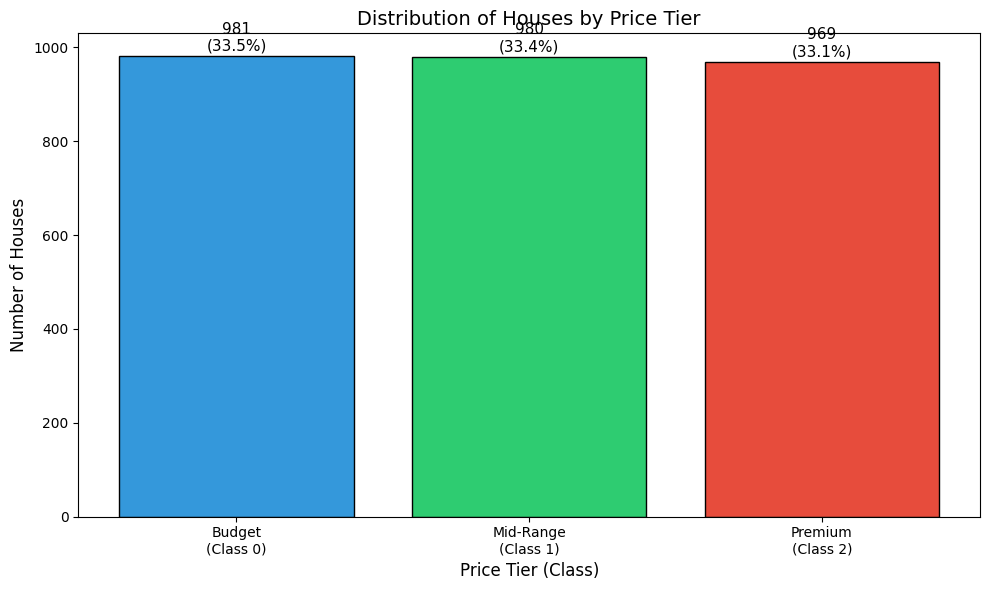

In [6]:
# Visualize the class distribution
fig, ax = plt.subplots(figsize=(10, 6))

# Create bar chart
bars = ax.bar(class_counts.index.astype(int), class_counts.values, 
              color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black')

# Add labels and title
ax.set_xlabel('Price Tier (Class)', fontsize=12)
ax.set_ylabel('Number of Houses', fontsize=12)
ax.set_title('Distribution of Houses by Price Tier', fontsize=14)

# Add custom x-axis labels
ax.set_xticks(class_counts.index.astype(int))
labels = [f"{class_names.get(int(i), f'Class {i}')}\n(Class {int(i)})" 
          for i in class_counts.index]
ax.set_xticklabels(labels)

# Add count and percentage labels on bars
for bar, (class_label, count) in zip(bars, class_counts.items()):
    percentage = (count / total_samples) * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{count:,}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

---
## Step 3: Prepare Data for SageMaker

Before training, we need to:
1. **Split the data** into training (80%) and validation (20%) sets
2. **Save to CSV files** in the format SageMaker expects (target column first, no headers)

**Why split the data?**
- **Training set**: Used to teach the model patterns in the data
- **Validation set**: Used to test how well the model performs on data it hasn't seen

This helps us detect "overfitting" - when a model memorizes the training data but can't generalize to new data.

**What to expect:** You'll see the sizes of your training and validation sets, plus the class distribution in each.

In [7]:
# Separate features (X) and target (y)
# The target is column 0, features are all other columns
y = df.iloc[:, 0]      # Target variable (what we want to predict)
X = df.iloc[:, 1:]     # Features (information used for prediction)

# Split into training (80%) and validation (20%) sets
# random_state=42 ensures we get the same split every time we run this code
# stratify=y ensures each class is proportionally represented in both sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2,      # 20% for validation
    random_state=42,    # For reproducibility
    stratify=y          # Keeps the same class proportions in both sets
)

print("="*60)
print("DATA SPLIT COMPLETE")
print("="*60)
print(f"Training set:   {len(X_train):,} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation set: {len(X_val):,} samples ({len(X_val)/len(df)*100:.1f}%)")
print(f"Features per sample: {X_train.shape[1]}")
print()
print("Class distribution in training set:")
for class_label in sorted(y_train.unique()):
    count = (y_train == class_label).sum()
    name = class_names.get(int(class_label), f'Class {int(class_label)}')
    print(f"  {name}: {count:,} ({count/len(y_train)*100:.1f}%)")

DATA SPLIT COMPLETE
Training set:   2,344 samples (80.0%)
Validation set: 586 samples (20.0%)
Features per sample: 197

Class distribution in training set:
  Budget: 785 (33.5%)
  Mid-Range: 784 (33.4%)
  Premium: 775 (33.1%)


In [8]:
# Combine target and features back together (target must be first column)
# SageMaker Linear Learner expects: target, feature1, feature2, ...
train_data = pd.concat([y_train.reset_index(drop=True), 
                        X_train.reset_index(drop=True)], axis=1)
val_data = pd.concat([y_val.reset_index(drop=True), 
                      X_val.reset_index(drop=True)], axis=1)

# Save to CSV files without headers or index
# SageMaker Linear Learner requires this specific format
train_file = "train_multiclass.csv"
val_file = "validation_multiclass.csv"

train_data.to_csv(train_file, index=False, header=False)
val_data.to_csv(val_file, index=False, header=False)

print(f"Training data saved to: {train_file}")
print(f"Validation data saved to: {val_file}")

Training data saved to: train_multiclass.csv
Validation data saved to: validation_multiclass.csv


---
## Step 4: Set Up SageMaker Session

Now we connect to AWS SageMaker. This involves:
1. Creating a **session** (connection to AWS)
2. Getting our **IAM role** (permissions to use AWS resources)
3. Identifying our **S3 bucket** (cloud storage for data)

**What is S3?**
Amazon S3 (Simple Storage Service) is like a hard drive in the cloud. SageMaker reads training data from S3 and saves trained models to S3.

**What is an IAM Role?**
IAM (Identity and Access Management) roles control what AWS services can do. Our role gives SageMaker permission to read our data and create resources. In AWS Learner Lab, this is pre-configured as "LabRole".

**What to expect:** You'll see the AWS region, S3 bucket name, and IAM role being used.

In [9]:
# Create a SageMaker session
# This establishes our connection to AWS SageMaker
sagemaker_session = Session()

# Get the IAM role that gives SageMaker permission to access resources
# In AWS Learner Lab, this is pre-configured as "LabRole"
role = get_execution_role()

# Get the default S3 bucket for this SageMaker session
# S3 buckets store our training data and model outputs
bucket = sagemaker_session.default_bucket()

# Get the AWS region we're working in
region = sagemaker_session.boto_region_name

# Create a prefix (folder path) for organizing our files in S3
prefix = f"sagemaker/{PROJECT_NAME}"

print("="*60)
print("SAGEMAKER SESSION CONFIGURED")
print("="*60)
print(f"AWS Region: {region}")
print(f"S3 Bucket: {bucket}")
print(f"S3 Prefix: {prefix}")
print(f"IAM Role: {role.split('/')[-1]}")  # Just show the role name

SAGEMAKER SESSION CONFIGURED
AWS Region: us-east-1
S3 Bucket: sagemaker-us-east-1-938371320235
S3 Prefix: sagemaker/multiclass-housing-demo
IAM Role: LabRole


---
## Step 5: Upload Data to S3

SageMaker training jobs read data from S3 (cloud storage), not from local files. We need to upload our training and validation CSV files to S3.

**Why S3?**
- SageMaker runs on cloud servers that don't have access to your local computer
- S3 provides fast, reliable storage that SageMaker can access
- Multiple training jobs can read the same data simultaneously

**What to expect:** You'll see the S3 paths (like web addresses) where your data was uploaded.

In [10]:
# Upload training data to S3
train_s3_uri = sagemaker_session.upload_data(
    path=train_file,       # Local file to upload
    bucket=bucket,         # S3 bucket name
    key_prefix=prefix      # Folder path within the bucket
)

# Upload validation data to S3
val_s3_uri = sagemaker_session.upload_data(
    path=val_file,
    bucket=bucket,
    key_prefix=prefix
)

print("="*60)
print("DATA UPLOADED TO S3")
print("="*60)
print(f"Training data:   {train_s3_uri}")
print(f"Validation data: {val_s3_uri}")

DATA UPLOADED TO S3
Training data:   s3://sagemaker-us-east-1-938371320235/sagemaker/multiclass-housing-demo/train_multiclass.csv
Validation data: s3://sagemaker-us-east-1-938371320235/sagemaker/multiclass-housing-demo/validation_multiclass.csv


---
## Step 6: Configure the Linear Learner Estimator

Now we configure the Linear Learner algorithm. An **Estimator** is SageMaker's way of defining:
- Which algorithm to use
- What type of computer (instance) to run it on
- Where to save the results

**Key Parameters Explained:**
- `predictor_type='multiclass_classifier'`: Tells Linear Learner we're predicting 3 or more classes
- `num_classes`: The number of different categories we're predicting (3 for our example)
- `feature_dim`: The number of input features (columns) in our data
- `mini_batch_size`: How many samples to process at once during training (a **training job** is the process where the computer learns patterns from your data)

**What to expect:** You'll see a summary of how the model is configured.

In [11]:
# Get the container image for Linear Learner
# This is a pre-built Docker image that contains the Linear Learner algorithm
container = sagemaker.image_uris.retrieve(
    framework="linear-learner",
    region=region
)

# Calculate the number of features (exclude the target column)
num_features = X_train.shape[1]

# Create the Estimator
# This configures HOW the model will be trained
linear_learner = Estimator(
    image_uri=container,                         # The algorithm container
    role=role,                                   # IAM role for permissions
    instance_count=1,                            # Number of training machines
    instance_type='ml.m5.large',                 # Machine type (Learner Lab compatible)
    output_path=f's3://{bucket}/{prefix}/output', # Where to save the trained model
    sagemaker_session=sagemaker_session
)

# Set the hyperparameters (settings that control how the algorithm learns)
linear_learner.set_hyperparameters(
    feature_dim=num_features,                # Number of input features
    predictor_type='multiclass_classifier',  # We're doing multi-class classification
    num_classes=NUM_CLASSES,                 # Number of classes to predict (3 for our example)
    mini_batch_size=100                      # Process 100 samples at a time
)

print("="*60)
print("LINEAR LEARNER CONFIGURED")
print("="*60)
print(f"Algorithm: Linear Learner")
print(f"Problem Type: Multi-class Classification")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Number of Features: {num_features}")
print(f"Training Instance: ml.m5.large")
print(f"Mini-batch Size: 100")

LINEAR LEARNER CONFIGURED
Algorithm: Linear Learner
Problem Type: Multi-class Classification
Number of Classes: 3
Number of Features: 197
Training Instance: ml.m5.large
Mini-batch Size: 100


---
## Step 7: Train the Model

Now we start the training job! This is where the computer learns patterns from your data.

**What happens during training?**
1. SageMaker spins up a cloud computer (the instance type we specified)
2. It downloads the training data from S3
3. The Linear Learner algorithm processes the data in mini-batches
4. It adjusts its internal weights to minimize prediction errors
5. The trained model is saved to S3

**This typically takes 3-5 minutes.** You'll see progress updates below.

**What to expect:** Training logs will appear showing the progress. When done, you'll see "TRAINING COMPLETE!"

In [12]:
# Create TrainingInput objects that tell SageMaker where to find the data
train_input = TrainingInput(
    s3_data=train_s3_uri,
    content_type="text/csv"  # Our data is in CSV format
)

val_input = TrainingInput(
    s3_data=val_s3_uri,
    content_type="text/csv"
)

print("Starting training job...")
print("This typically takes 3-5 minutes. Please wait.")
print()

# Start the training job
# The fit() method blocks until training is complete
linear_learner.fit(
    inputs={
        'train': train_input,
        'validation': val_input
    }
)

print()
print("="*60)
print("TRAINING COMPLETE!")
print("="*60)

INFO:sagemaker:Creating training-job with name: linear-learner-2026-01-28-12-45-52-989


Starting training job...
This typically takes 3-5 minutes. Please wait.

2026-01-28 12:45:54 Starting - Starting the training job...
2026-01-28 12:46:10 Starting - Preparing the instances for training...
2026-01-28 12:46:36 Downloading - Downloading input data...
2026-01-28 12:47:17 Downloading - Downloading the training image........Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/28/2026 12:48:37 INFO 139759327917888] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin

---
## Step 8: Deploy the Model

The trained model is just a file in S3. To use it for predictions, we need to **deploy** it to an **endpoint**.

**What is an Endpoint?**
An endpoint is like a web address (URL) where you can send data and get predictions back. It's a cloud server running your trained model 24/7, ready to make predictions.

**Important Cost Note:**
Endpoints cost money as long as they're running! Always delete endpoints when you're done (Step 11).

**This typically takes 3-5 minutes.**

**What to expect:** You'll see a message when the endpoint is ready to receive predictions.

In [13]:
# ============================================================
# HELPER FUNCTION: Safe endpoint cleanup
# ============================================================
# This function handles all the tricky edge cases when students run
# the notebook multiple times (endpoint creating, deleting, etc.)

import time

def wait_for_endpoint_deletion(sm_client, endpoint_name, max_wait_minutes=15):
    """
    Safely wait for an endpoint to be fully deleted.
    Handles all endpoint states: Creating, InService, Updating, Deleting, Failed
    Also cleans up the endpoint configuration to prevent conflicts on re-deployment.
    """
    print(f"Checking endpoint status for '{endpoint_name}'...")
    
    start_time = time.time()
    max_wait_seconds = max_wait_minutes * 60
    
    while True:
        # Check if we have exceeded max wait time
        elapsed = time.time() - start_time
        if elapsed > max_wait_seconds:
            print(f"WARNING: Timed out after {max_wait_minutes} minutes.")
            print("The endpoint may still be processing. Please check the SageMaker console.")
            return False
        
        try:
            response = sm_client.describe_endpoint(EndpointName=endpoint_name)
            status = response['EndpointStatus']
            
            if status == 'InService':
                print(f"  Endpoint is InService. Requesting deletion...")
                sm_client.delete_endpoint(EndpointName=endpoint_name)
                print(f"  Deletion requested. Waiting for completion...")
            
            elif status == 'Creating':
                # Cannot delete while creating - must wait for it to finish first
                mins_elapsed = int(elapsed // 60)
                secs_elapsed = int(elapsed % 60)
                print(f"  Endpoint is being created ({mins_elapsed}m {secs_elapsed}s elapsed)...")
                print(f"  Cannot delete until creation completes. Please wait...")
            
            elif status == 'Updating':
                # Cannot delete while updating - must wait
                print(f"  Endpoint is being updated. Waiting for it to finish...")
            
            elif status == 'Deleting':
                mins_elapsed = int(elapsed // 60)
                secs_elapsed = int(elapsed % 60)
                print(f"  Endpoint is being deleted ({mins_elapsed}m {secs_elapsed}s elapsed)...")
            
            elif status == 'Failed':
                print(f"  Endpoint is in Failed state. Requesting deletion...")
                try:
                    sm_client.delete_endpoint(EndpointName=endpoint_name)
                except:
                    pass  # May already be cleaning up
            
            else:
                print(f"  Endpoint status: {status}. Waiting...")
            
            # Wait before checking again
            time.sleep(15)
        
        except sm_client.exceptions.ClientError as e:
            if 'Could not find endpoint' in str(e):
                print(f"  Endpoint '{endpoint_name}' has been fully deleted (or never existed).")
                # NOW ALSO DELETE THE ENDPOINT CONFIGURATION
                try:
                    sm_client.delete_endpoint_config(EndpointConfigName=endpoint_name)
                    print(f"  Endpoint configuration '{endpoint_name}' deleted.")
                except sm_client.exceptions.ClientError as config_error:
                    if 'Could not find endpoint configuration' in str(config_error):
                        print(f"  Endpoint configuration already deleted (or never existed).")
                    else:
                        print(f"  Note: Could not delete endpoint config: {config_error}")
                return True
            else:
                print(f"  Unexpected error: {e}")
                return False

# Create the SageMaker client
sm_client = boto3.client('sagemaker')

# FIRST: Clean up any existing endpoint configuration (even if endpoint does not exist)
try:
    sm_client.delete_endpoint_config(EndpointConfigName=ENDPOINT_NAME)
    print(f"Deleted existing endpoint configuration '{ENDPOINT_NAME}'.")
except sm_client.exceptions.ClientError as e:
    if 'Could not find endpoint configuration' in str(e):
        pass  # No config exists, which is fine
    else:
        print(f"Note: {e}")

# Check if endpoint exists and clean it up if necessary
try:
    response = sm_client.describe_endpoint(EndpointName=ENDPOINT_NAME)
    status = response['EndpointStatus']
    print(f"Found existing endpoint '{ENDPOINT_NAME}' with status: {status}")
    print("Cleaning up before deployment...")
    print()
    success = wait_for_endpoint_deletion(sm_client, ENDPOINT_NAME)
    if success:
        print()
        print("Cleanup complete! Ready for deployment.")
    else:
        print()
        print("WARNING: Cleanup may not be complete. Proceeding anyway...")
except sm_client.exceptions.ClientError:
    print(f"No existing endpoint named '{ENDPOINT_NAME}' found. Ready for deployment.")

print()
print("Deploying model to endpoint...")
print("This typically takes 3-5 minutes. Please wait.")
print()

Deleted existing endpoint configuration 'multiclass-learner-endpoint'.
No existing endpoint named 'multiclass-learner-endpoint' found. Ready for deployment.

Deploying model to endpoint...
This typically takes 3-5 minutes. Please wait.



In [14]:
# Deploy the trained model to create a prediction endpoint
predictor = linear_learner.deploy(
    initial_instance_count=1,       # Number of servers to run the model
    instance_type='ml.m5.large',    # Server type (Learner Lab compatible)
    endpoint_name=ENDPOINT_NAME     # Name for the endpoint
)

# Configure how to send data to and receive data from the endpoint
predictor.serializer = CSVSerializer()      # Send data as CSV
predictor.deserializer = JSONDeserializer() # Receive responses as JSON

print("="*60)
print("MODEL DEPLOYED SUCCESSFULLY!")
print("="*60)
print(f"Endpoint Name: {ENDPOINT_NAME}")
print(f"Endpoint is now ready to receive predictions.")

INFO:sagemaker:Creating model with name: linear-learner-2026-01-28-12-49-40-791
INFO:sagemaker:Creating endpoint-config with name multiclass-learner-endpoint
INFO:sagemaker:Creating endpoint with name multiclass-learner-endpoint


-------!============================================================
MODEL DEPLOYED SUCCESSFULLY!
Endpoint Name: multiclass-learner-endpoint
Endpoint is now ready to receive predictions.


---
## Step 9: Test the Deployed Model

Let's test the model by sending some sample data and getting predictions.

**What the model returns for multi-class classification:**
- `score`: An array of probabilities for each class (should sum to approximately 1.0)
- The predicted class is the one with the highest probability

**What to expect:** You'll see predictions for 5 sample houses, showing the predicted class, probabilities for each class, actual class, and whether the prediction was correct.

In [15]:
# Test with a few samples from the validation set
# We'll use the first 5 samples
test_samples = X_val.head(5).values
actual_labels = y_val.head(5).values

# Send the samples to the endpoint for prediction
response = predictor.predict(test_samples)

print("="*60)
print("SAMPLE PREDICTIONS")
print("="*60)
print()

# Display results for each sample
for i, prediction in enumerate(response['predictions']):
    # For multiclass, 'score' is an array of probabilities
    scores = prediction['score']
    predicted_class = np.argmax(scores)  # Class with highest probability
    confidence = scores[predicted_class]
    actual = int(actual_labels[i])
    
    # Get class names
    predicted_name = class_names.get(predicted_class, f'Class {predicted_class}')
    actual_name = class_names.get(actual, f'Class {actual}')
    
    # Determine if prediction was correct
    status = "CORRECT" if predicted_class == actual else "WRONG"
    
    print(f"Sample {i+1}:")
    print(f"  Predicted: {predicted_name} (Class {predicted_class}) - Confidence: {confidence:.2%}")
    print(f"  Actual:    {actual_name} (Class {actual})")
    print(f"  All probabilities: ", end="")
    for j, prob in enumerate(scores):
        name = class_names.get(j, f'Class {j}')
        print(f"{name}: {prob:.2%}  ", end="")
    print()
    print(f"  Result:    {status}")
    print()

SAMPLE PREDICTIONS

Sample 1:
  Predicted: Premium (Class 2) - Confidence: 99.99%
  Actual:    Premium (Class 2)
  All probabilities: Budget: 0.00%  Mid-Range: 0.01%  Premium: 99.99%  
  Result:    CORRECT

Sample 2:
  Predicted: Premium (Class 2) - Confidence: 90.16%
  Actual:    Mid-Range (Class 1)
  All probabilities: Budget: 0.00%  Mid-Range: 9.84%  Premium: 90.16%  
  Result:    WRONG

Sample 3:
  Predicted: Budget (Class 0) - Confidence: 100.00%
  Actual:    Budget (Class 0)
  All probabilities: Budget: 100.00%  Mid-Range: 0.00%  Premium: 0.00%  
  Result:    CORRECT

Sample 4:
  Predicted: Budget (Class 0) - Confidence: 99.99%
  Actual:    Budget (Class 0)
  All probabilities: Budget: 99.99%  Mid-Range: 0.01%  Premium: 0.00%  
  Result:    CORRECT

Sample 5:
  Predicted: Mid-Range (Class 1) - Confidence: 93.09%
  Actual:    Mid-Range (Class 1)
  All probabilities: Budget: 5.91%  Mid-Range: 93.09%  Premium: 1.01%  
  Result:    CORRECT



### Business Interpretation

For our real estate example:
- **Class 0 (Budget)**: Lower-priced homes, targeting first-time buyers
- **Class 1 (Mid-Range)**: Average-priced homes, the typical family market
- **Class 2 (Premium)**: Higher-priced homes, luxury market

The **probability scores** for each class tell you how confident the model is:
- If one class has high probability (>70%), the model is confident
- If probabilities are spread across classes, the house is on the boundary between tiers

Use this information to:
- Identify "tweener" properties that could be positioned in different segments
- Prioritize marketing based on the most likely buyer segment
- Understand which features drive homes into premium vs. budget categories

---
## Step 10: Evaluate Model Performance

Now let's evaluate how well the model performs on the entire validation set.

**Key Metrics Explained (in plain language for multi-class):**

- **Accuracy**: The percentage of all predictions that were correct
  - Example: 75% accuracy means 75 out of 100 predictions were right

- **Precision (per class)**: Of all predictions for a specific class, what percentage were correct?
  - Example: 80% precision for Premium means 80% of "Premium" predictions were actually Premium

- **Recall (per class)**: Of all actual instances of a class, what percentage did we correctly identify?
  - Example: 70% recall for Budget means we correctly identified 70% of Budget homes

- **F1 Score**: A balanced combination of precision and recall for each class

**Confusion Matrix**: A grid showing which classes get confused with which other classes
- Rows = actual classes, Columns = predicted classes
- Diagonal = correct predictions, off-diagonal = errors

**What to expect:** You'll see overall accuracy, per-class metrics, and a visual confusion matrix.

In [16]:
# Get predictions for the entire validation set
# Process in batches to avoid timeout issues with large datasets
print("Evaluating model on full validation set...")

all_predictions = []
batch_size = 100

for i in range(0, len(X_val), batch_size):
    batch = X_val.iloc[i:i+batch_size].values
    response = predictor.predict(batch)
    # For multiclass, get the class with highest probability
    batch_predictions = [np.argmax(p['score']) for p in response['predictions']]
    all_predictions.extend(batch_predictions)

# Convert to numpy array
y_pred = np.array(all_predictions)
y_true = y_val.values.astype(int)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print()
print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print()
print(f"Overall Accuracy:  {accuracy:.2%}  (What percentage of predictions were correct?)")
print(f"Weighted Precision: {precision:.2%}  (Average precision across all classes)")
print(f"Weighted Recall:    {recall:.2%}  (Average recall across all classes)")
print(f"Weighted F1 Score:  {f1:.2%}  (Balanced measure of precision and recall)")

Evaluating model on full validation set...

MODEL PERFORMANCE METRICS

Overall Accuracy:  86.01%  (What percentage of predictions were correct?)
Weighted Precision: 86.03%  (Average precision across all classes)
Weighted Recall:    86.01%  (Average recall across all classes)
Weighted F1 Score:  86.01%  (Balanced measure of precision and recall)


In [17]:
# Display the confusion matrix
cm = confusion_matrix(y_true, y_pred)

print()
print("="*60)
print("CONFUSION MATRIX")
print("="*60)
print()
print("                           Predicted")
print("                   Budget  Mid-Range  Premium")
print("         Budget   [{:5d}]   [{:5d}]   [{:5d}]".format(cm[0,0], cm[0,1], cm[0,2]))
print("Actual   Mid-Range [{:5d}]   [{:5d}]   [{:5d}]".format(cm[1,0], cm[1,1], cm[1,2]))
print("         Premium  [{:5d}]   [{:5d}]   [{:5d}]".format(cm[2,0], cm[2,1], cm[2,2]))
print()

# Calculate per-class accuracy
print("Per-class accuracy:")
for i in range(NUM_CLASSES):
    class_total = cm[i, :].sum()
    class_correct = cm[i, i]
    class_acc = class_correct / class_total if class_total > 0 else 0
    name = class_names.get(i, f'Class {i}')
    print(f"  {name}: {class_acc:.1%} ({class_correct}/{class_total})")


CONFUSION MATRIX

                           Predicted
                   Budget  Mid-Range  Premium
         Budget   [  170]   [   26]   [    0]
Actual   Mid-Range [   22]   [  156]   [   18]
         Premium  [    0]   [   16]   [  178]

Per-class accuracy:
  Budget: 86.7% (170/196)
  Mid-Range: 79.6% (156/196)
  Premium: 91.8% (178/194)


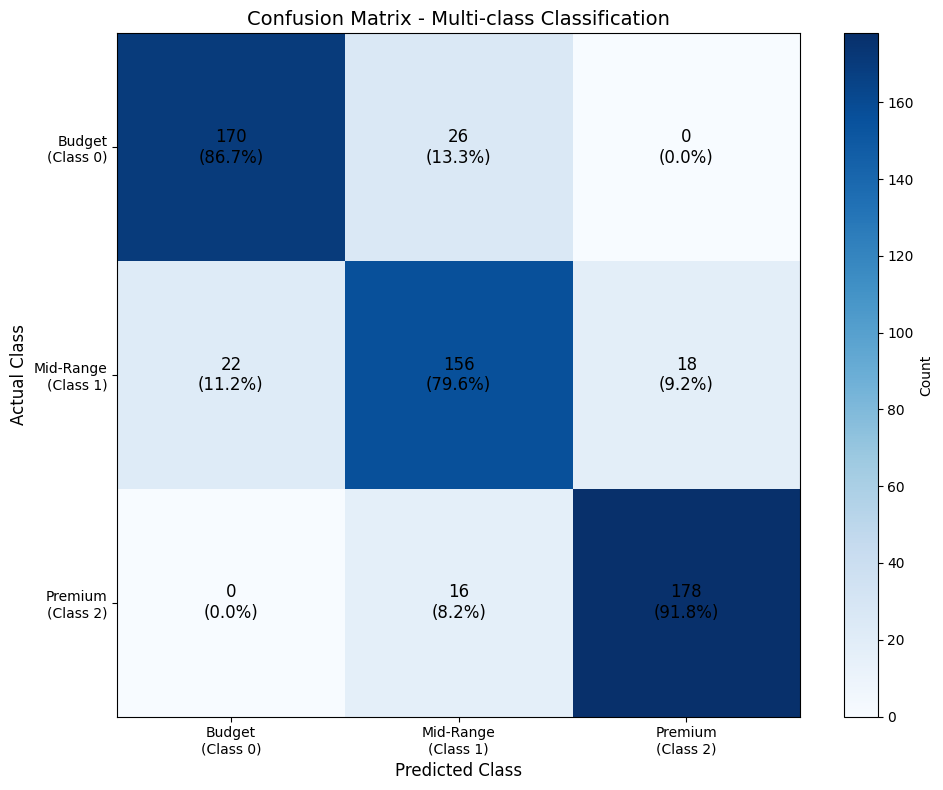

Diagonal cells (top-left to bottom-right) show correct predictions.
Off-diagonal cells show misclassifications.


In [18]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap
im = ax.imshow(cm, cmap='Blues')

# Add labels
labels = [class_names.get(i, f'Class {i}') for i in range(NUM_CLASSES)]
ax.set_xticks(range(NUM_CLASSES))
ax.set_yticks(range(NUM_CLASSES))
ax.set_xticklabels([f"{l}\n(Class {i})" for i, l in enumerate(labels)])
ax.set_yticklabels([f"{l}\n(Class {i})" for i, l in enumerate(labels)])
ax.set_xlabel('Predicted Class', fontsize=12)
ax.set_ylabel('Actual Class', fontsize=12)
ax.set_title('Confusion Matrix - Multi-class Classification', fontsize=14)

# Add text annotations with counts and percentages
for i in range(NUM_CLASSES):
    row_total = cm[i, :].sum()
    for j in range(NUM_CLASSES):
        pct = cm[i, j] / row_total * 100 if row_total > 0 else 0
        text = ax.text(j, i, f'{cm[i, j]}\n({pct:.1f}%)',
                       ha='center', va='center', fontsize=12)

plt.colorbar(im, label='Count')
plt.tight_layout()
plt.show()

print("Diagonal cells (top-left to bottom-right) show correct predictions.")
print("Off-diagonal cells show misclassifications.")

In [22]:
# ============================================================
# SINGLE POINT PREDICTION
# ============================================================
# Paste your feature values as a comma-separated string below.
# This should include ALL features (excluding the target variable).

input_values = """
20.0,68.0,11382.0,0.15119454,6.0,5.0,1964.0,1964.0,0.14334472,0.09351536,212.0,54.0,543.0,533.0,1130.0,1374.0,0.0,0.0,1374.0,0.0,1.0,1.0,0.0,3.0,1.0,7.0,1.0,1964.0,1.0,286.0,0.0,28.0,84.0,0.0,0.0,0.0,0.0,8.0,2007.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
"""

# Parse the input
values = [float(x.strip()) for x in input_values.strip().split(',')]
sample = np.array(values).reshape(1, -1)

# Verify feature count matches training data
expected_features = X_train.shape[1]
if len(values) != expected_features:
    print(f"ERROR: You provided {len(values)} features, but the model expects {expected_features}.")
else:
    # Make prediction
    response = predictor.predict(sample)
    prediction = response['predictions'][0]
    
    predicted_class = int(prediction['predicted_label'])
    
    # For multi-class, 'score' is a list of probabilities for each class
    scores = prediction['score']
    confidence = float(scores[predicted_class])  # Get probability of predicted class
    
    # Interpret confidence
    if confidence >= 0.9:
        confidence_level = "VERY HIGH"
    elif confidence >= 0.75:
        confidence_level = "HIGH"
    elif confidence >= 0.6:
        confidence_level = "MODERATE"
    else:
        confidence_level = "LOW"
    
    print("=" * 60)
    print("SINGLE POINT PREDICTION - MULTI-CLASS CLASSIFICATION")
    print("=" * 60)
    print()
    print(f"  PREDICTED CLASS: {predicted_class}")
    print(f"  CONFIDENCE:      {confidence:.1%} ({confidence_level})")
    print()
    print("-" * 60)
    print("Class Probabilities:")
    
    # Display probabilities for all classes
    for i, score in enumerate(scores):
        bar_length = int(score * 30)
        bar = "█" * bar_length + "░" * (30 - bar_length)
        marker = " ← PREDICTED" if i == predicted_class else ""
        print(f"  Class {i}: {score:6.1%} |{bar}|{marker}")
    
    print()
    print(f"The model is {confidence:.1%} confident in this prediction.")

SINGLE POINT PREDICTION - MULTI-CLASS CLASSIFICATION

  PREDICTED CLASS: 1
  CONFIDENCE:      86.6% (HIGH)

------------------------------------------------------------
Class Probabilities:
  Class 0:  13.3% |███░░░░░░░░░░░░░░░░░░░░░░░░░░░|
  Class 1:  86.6% |█████████████████████████░░░░░| ← PREDICTED
  Class 2:   0.2% |░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░|

The model is 86.6% confident in this prediction.


---
## Step 11: Clean Up Resources

**IMPORTANT: Endpoints cost money as long as they're running!** In AWS Learner Lab, leaving endpoints running will consume your budget.

Run the cell below when you're done to delete your endpoint.

**What gets deleted:**
- The endpoint (the running prediction server)

**What is NOT deleted:**
- Your trained model (saved in S3) - you can re-deploy later if needed
- Your training data (saved in S3)

In [19]:
# ============================================================
# CLEANUP: Delete existing endpoint and configuration
# ============================================================
# Run this cell to check for and remove any existing endpoint
# with the same name. This prevents conflicts when re-running
# the notebook.

import time
import boto3

sm_client = boto3.client('sagemaker')

# Check what exists
endpoint_exists = False
endpoint_config_exists = False
endpoint_status = None

try:
    response = sm_client.describe_endpoint(EndpointName=ENDPOINT_NAME)
    endpoint_exists = True
    endpoint_status = response['EndpointStatus']
except sm_client.exceptions.ClientError:
    pass

try:
    sm_client.describe_endpoint_config(EndpointConfigName=ENDPOINT_NAME)
    endpoint_config_exists = True
except sm_client.exceptions.ClientError:
    pass

# Report what was found
print("=" * 60)
print("ENDPOINT CLEANUP CHECK")
print("=" * 60)
print(f"Endpoint name: {ENDPOINT_NAME}")
print()

if not endpoint_exists and not endpoint_config_exists:
    print("No existing endpoint or configuration found.")
    print("You are ready to deploy!")
else:
    if endpoint_exists:
        print(f"FOUND: Endpoint (status: {endpoint_status})")
    if endpoint_config_exists:
        print(f"FOUND: Endpoint configuration")
    print()
    
    # Prompt for confirmation
    confirm = input("Delete these resources? Type 'yes' to confirm: ")
    
    if confirm.lower() == 'yes':
        print()
        print("Deleting resources...")
        
        # Delete endpoint first (if it exists)
        if endpoint_exists:
            print(f"  Deleting endpoint '{ENDPOINT_NAME}'...")
            sm_client.delete_endpoint(EndpointName=ENDPOINT_NAME)
            
            # Wait for endpoint deletion to complete
            while True:
                try:
                    response = sm_client.describe_endpoint(EndpointName=ENDPOINT_NAME)
                    status = response['EndpointStatus']
                    print(f"    Status: {status}... waiting 15 seconds")
                    time.sleep(15)
                except sm_client.exceptions.ClientError as e:
                    if 'Could not find endpoint' in str(e):
                        print(f"  Endpoint deleted successfully.")
                        break
                    else:
                        raise e
        
        # Delete endpoint configuration (if it exists)
        if endpoint_config_exists:
            print(f"  Deleting endpoint configuration '{ENDPOINT_NAME}'...")
            try:
                sm_client.delete_endpoint_config(EndpointConfigName=ENDPOINT_NAME)
                print(f"  Endpoint configuration deleted successfully.")
            except sm_client.exceptions.ClientError as e:
                if 'Could not find endpoint configuration' in str(e):
                    print(f"  Endpoint configuration already deleted.")
                else:
                    raise e
        
        print()
        print("Cleanup complete! You are ready to deploy.")
    else:
        print()
        print("Deletion cancelled. Existing resources were not changed.")
        print("Note: Deployment may fail if you proceed without cleanup.")

ENDPOINT CLEANUP CHECK
Endpoint name: multiclass-learner-endpoint

FOUND: Endpoint (status: InService)
FOUND: Endpoint configuration



Delete these resources? Type 'yes' to confirm:  No



Deletion cancelled. Existing resources were not changed.
Note: Deployment may fail if you proceed without cleanup.


---
## Troubleshooting

### Common Errors and Solutions

**"ResourceLimitExceeded" error during training or deployment**
- You may have hit your AWS Learner Lab instance limit
- Solution: Delete any existing endpoints in the SageMaker console, then try again

**"ValidationException: Could not find endpoint" error**
- The endpoint does not exist (may have been deleted or never created)
- Solution: Re-run the deployment cell (Step 8)

**"Endpoint is being created" message takes a long time**
- This is normal! If you previously started creating an endpoint and then re-ran the notebook, 
  the code must wait for the previous creation to complete before it can delete it
- The code will automatically wait up to 15 minutes - just be patient
- If it times out, check the SageMaker console and manually delete the endpoint

**"Cannot create endpoint - endpoint already exists" error**
- This means the cleanup did not complete successfully
- Solution: Go to SageMaker console -> Endpoints -> Delete the endpoint manually, then retry

**Training job fails immediately**
- Check that your CSV file format is correct (target first, no headers)
- Ensure all values are numeric
- Verify the file was uploaded to S3 correctly
- For multi-class: ensure target values are consecutive integers starting at 0 (i.e., 0, 1, 2, ... not 1, 2, 3)
- Verify NUM_CLASSES matches the actual number of unique values in your target column

**"ModelError" when making predictions**
- The input data format may not match what the model expects
- Ensure you are sending the same number of features as in training
- Check that all values are numeric

**Model always predicts the same class**
- This often indicates severe class imbalance
- Check that all classes are represented in your training data
- Consider if the classes are actually distinguishable

### Session and Timeout Issues

**AWS Learner Lab sessions expire after 4 hours!**
- This is a hard limit - your session will end and resources may be terminated
- Plan your work accordingly: start the notebook, complete training, make predictions, and clean up within the 4-hour window
- If your session expires mid-training, you will need to restart from the beginning in a new session
- Always delete your endpoint before the session expires to avoid unexpected charges

**Session timeout or connection errors**
- AWS Learner Lab sessions expire after 4 hours (see above)
- Solution: Start a new lab session, but note you will need to re-run the notebook from the beginning
- Tip: Save your work frequently and keep track of which cells you have completed

### Running the Notebook Multiple Times

If you run this notebook multiple times (which is totally normal when learning!), the code 
will automatically handle cleaning up old endpoints. Here is what happens:

1. **If no endpoint exists**: Deployment starts immediately
2. **If endpoint is "InService"**: It gets deleted, then the new one is deployed
3. **If endpoint is "Creating"**: The code waits for creation to finish, then deletes it
4. **If endpoint is "Deleting"**: The code waits for deletion to complete

**Tip**: If things get stuck, you can always manually delete endpoints from the 
SageMaker console: Services -> SageMaker -> Inference -> Endpoints

### AWS Learner Lab Specific Issues

**"AccessDeniedException" errors**
- Some AWS features are restricted in Learner Lab
- Stick to the supported instance types: ml.t3.medium, ml.t3.large, ml.t3.xlarge, ml.m5.large, ml.m5.xlarge, ml.c5.large, ml.c5.xlarge

**Running out of budget**
- Always delete endpoints when done
- Avoid leaving training jobs running unnecessarily
- Monitor your budget in the Learner Lab interface

**Notebook instance stopped unexpectedly**
- SageMaker notebook instances auto-stop when the lab session ends
- Your work is saved; just restart the instance in your next session

---
## Summary

Congratulations! You have successfully:

1. Loaded and verified a cleaned dataset
2. Split data into training and validation sets (with stratification)
3. Uploaded data to Amazon S3 (cloud storage)
4. Configured and trained a Linear Learner model for multi-class classification
5. Deployed the model to a prediction endpoint
6. Made predictions and evaluated model performance
7. Cleaned up resources to protect your budget

### Key Takeaways for Multi-class Classification

- Multi-class classification predicts **one of three or more categories**
- The model outputs probabilities for each class, not just the predicted class
- The confusion matrix shows which classes get confused with each other
- Per-class metrics help identify which categories are easier or harder to predict
- **Critical**: You must set `num_classes` to match your data
- **Critical**: Class labels must be consecutive integers starting at 0 (0, 1, 2, ... not 1, 2, 3)
- Always clean up endpoints to avoid unnecessary costs

### How Multi-class Classification Differs from Other Problem Types

| Aspect | Regression | Binary Classification | Multi-class Classification (This Notebook) |
|--------|------------|----------------------|-------------------------------------------|
| **Business Question** | "How much?" or "How many?" | "Yes or no?" | "Which category?" |
| **Prediction Output** | A single number | 0 or 1 (with probability) | One of 3+ classes (with probabilities) |
| **Example** | Predict exact price: $185,000 | Above/below median? (yes/no) | Budget/Mid-Range/Premium? |
| **predictor_type** | `'regressor'` | `'binary_classifier'` | `'multiclass_classifier'` |
| **num_classes** | Not needed | Not needed | **Required** (e.g., 3) |
| **Target values** | Any numeric value | 0 or 1 | 0, 1, 2, ... (starting at 0) |
| **Key metrics** | RMSE, MAE, R-squared | Accuracy, Precision, Recall, F1 | Accuracy, Per-class metrics |
| **Visualization** | Predicted vs Actual scatter | Confusion Matrix (2x2) | Confusion Matrix (NxN) |

### When to Use Multi-class Classification

Use multi-class classification when:
- You need to categorize items into 3 or more groups
- The categories are mutually exclusive (each item belongs to exactly one category)
- You want to see probabilities for each possible category

Examples: product categorization, risk tier assignment (low/medium/high), sentiment analysis (negative/neutral/positive), customer segmentation

### Understanding the Confusion Matrix for Multi-class

The NxN confusion matrix shows:
- **Diagonal cells**: Correct predictions (each row's actual class matches the column's predicted class)
- **Off-diagonal cells**: Misclassifications (shows which classes get confused with which)
- **Row sums**: Total actual samples for each class
- **Column sums**: Total predictions for each class

Look for patterns in misclassifications:
- Are adjacent classes confused? (e.g., Mid-Range confused with Budget or Premium)
- Is one class consistently mispredicted?

### Next Steps

- **Regression notebook**: When you need an exact numeric prediction (e.g., "What price will this sell for?")
- **Binary Classification notebook**: When your question is yes/no (e.g., "Will this customer churn?")
- **Your own project**: Use the Data Validator notebook to prepare your own dataset